In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
from scipy.signal import find_peaks, savgol_filter
sys.path.insert(0, 'Templates Sarah/Temperature/')
import extractTemperature_auto as ET
cwd = os.getcwd()



In [4]:
# Read the data
# Port 1, i.e. memory cell
data1 = pd.read_csv('Data/elecsus_cells_66C1_1.csv')
# Port 4, i.e. natural abundance cell
data4 = pd.read_csv('Data/elecsus_cells_66C1_4.csv')

# Drop first row
data1 = data1.drop(0)
data4 = data4.drop(0)

In [5]:
# Rename columns
data1.columns = ['Time', 'Voltage']
data4.columns = ['Time', 'Voltage']

data1 = data1.astype(float)
data4 = data4.astype(float)

In [9]:
# Drop index
data1 = data1.reset_index(drop=True)
data4 = data4.reset_index(drop=True)


In [12]:
data1['Time'].values

array([0.11312514, 0.11312714, 0.11312914, ..., 0.31311914, 0.31312114,
       0.31312314])

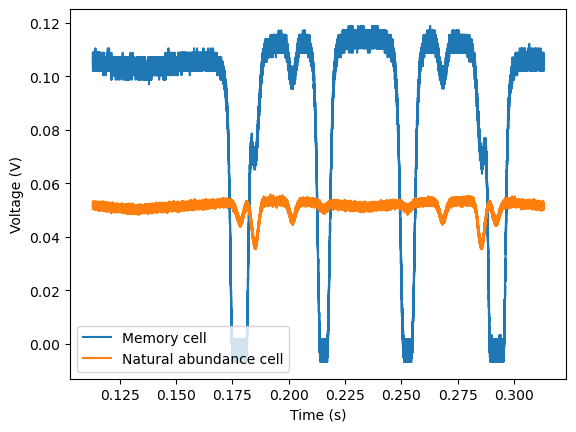

In [13]:
# Plot the data

plt.plot(data1['Time'].values, data1['Voltage'].values, label='Memory cell')
plt.plot(data4['Time'].values, data4['Voltage'].values, label='Natural abundance cell')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

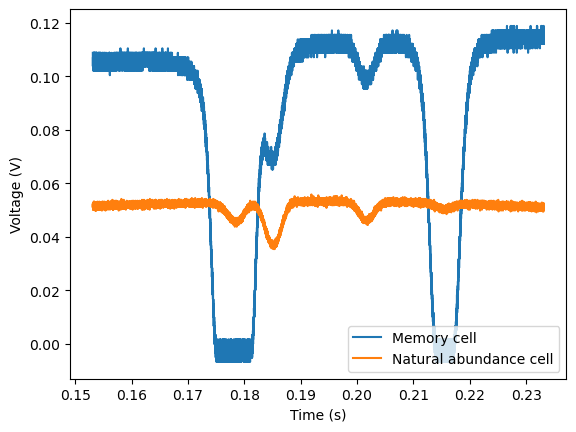

In [17]:
# Define data of single scan
index_start = 20000
index_end = 60000

data1_single = data1[index_start:index_end]
data4_single = data4[index_start:index_end]

# Plot the data
plt.plot(data1_single['Time'].values, data1_single['Voltage'].values, label='Memory cell')
plt.plot(data4_single['Time'].values, data4_single['Voltage'].values, label='Natural abundance cell')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

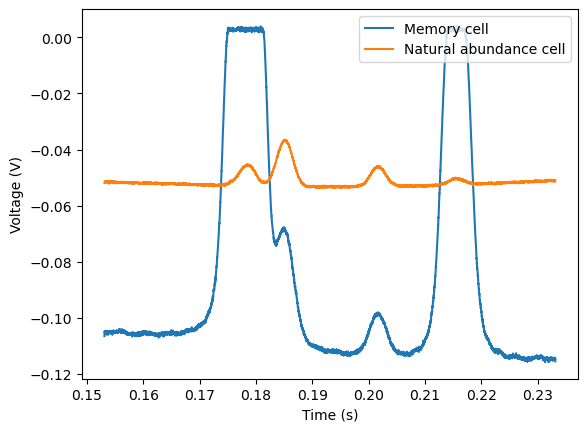

In [20]:
# Smoothen the data
data1_single['Voltage_smooth'] = savgol_filter(data1_single['Voltage'], 51, 3)
data4_single['Voltage_smooth'] = savgol_filter(data4_single['Voltage'], 51, 3)

# Plot the data
plt.plot(data1_single['Time'].values, -data1_single['Voltage_smooth'].values, label='Memory cell')
plt.plot(data4_single['Time'].values, -data4_single['Voltage_smooth'].values, label='Natural abundance cell')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()


1.1789656663200087e-05


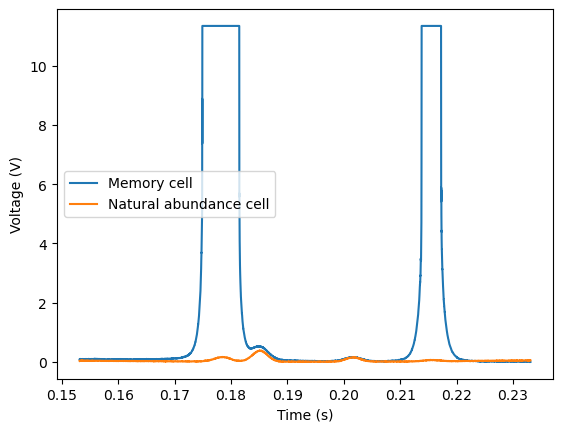

In [59]:
# Normalize the data
data1_single['Voltage_smooth_norm'] = data1_single['Voltage_smooth'] / np.max(data1_single['Voltage_smooth'])
data4_single['Voltage_smooth_norm'] = data4_single['Voltage_smooth'] / np.max(data4_single['Voltage_smooth'])

# Get smallest, positive value
min_val = min(data1_single['Voltage_smooth_norm'].values[np.where(data1_single['Voltage_smooth_norm'] > 0)])
print(min_val)

# Replace negative and zero values with 1e-2
data1_single['Voltage_smooth_norm'] = data1_single['Voltage_smooth_norm'].apply(lambda x: min_val if x <= 0 else x)
data4_single['Voltage_smooth_norm'] = data4_single['Voltage_smooth_norm'].apply(lambda x: min_val if x <= 0 else x)

# print(min(data1_single['Voltage_smooth_norm'].values))

data1_single['Voltage_smooth_norm'] = -np.log(data1_single['Voltage_smooth_norm'])
data4_single['Voltage_smooth_norm'] = -np.log(data4_single['Voltage_smooth_norm'])

# Plot the data
plt.plot(data1_single['Time'].values, data1_single['Voltage_smooth_norm'].values, label='Memory cell')
plt.plot(data4_single['Time'].values, data4_single['Voltage_smooth_norm'].values, label='Natural abundance cell')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()


11.348287964856825


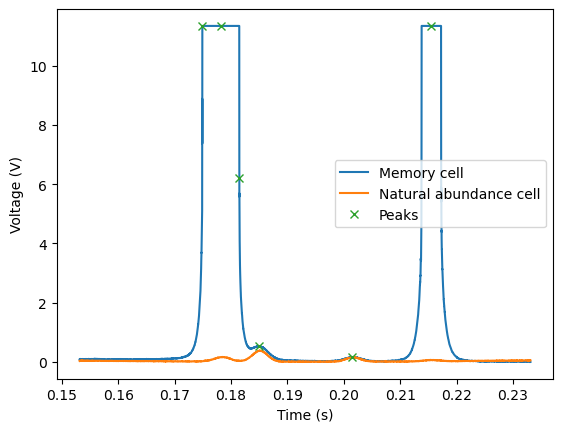

In [78]:
# Find dips in memory cell
peaks1, _ = find_peaks(data1_single['Voltage_smooth_norm'], prominence=0.05, distance=1000)

# Convert peak indices to time
time_peaks1 = data1_single['Time'].values[peaks1]
print(max(data1_single['Voltage_smooth_norm'].values))

# Plot the data with peaks
plt.plot(data1_single['Time'].values, data1_single['Voltage_smooth_norm'].values, label='Memory cell')
plt.plot(data4_single['Time'].values, data4_single['Voltage_smooth_norm'].values, label='Natural abundance cell')
plt.plot(time_peaks1, data1_single['Voltage_smooth_norm'].values[peaks1], 'x', label='Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()



In [77]:
_Rb87F1 = 4.15; _Rb85F1 = 1.675; _Rb85F2 = -1.232; _Rb87F2 = -2.366

# Define dips as the second, fourth, fifth and sixth dip
dips = [1, 3, 4, 5]
time_dips1 = time_peaks1[dips]

[-6.78102074 -6.78067085 -6.78032096 ...  7.21364614  7.21399603
  7.21434592]


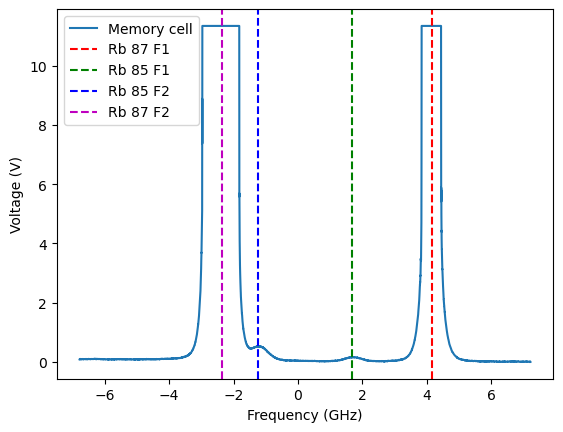

In [85]:
# Map the dips to the corresponding Rb transitions (in relative frequency)
freq_Rb = np.array([_Rb87F2, _Rb85F2, _Rb85F1, _Rb87F1])

# Transform the time axis to frequency axis
freq_array = np.polyval(np.polyfit(peaks1[dips], freq_Rb, 1), np.linspace(0, len(data1_single['Time'].values), len(data1_single['Time'].values)))
print(freq_array)

# Plot the data with peaks and frequency axis
plt.plot(freq_array, data1_single['Voltage_smooth_norm'].values, label='Memory cell')
plt.axvline(x=_Rb87F1, color='r', linestyle='--', label='Rb 87 F1')
plt.axvline(x=_Rb85F1, color='g', linestyle='--', label='Rb 85 F1')
plt.axvline(x=_Rb85F2, color='b', linestyle='--', label='Rb 85 F2')
plt.axvline(x=_Rb87F2, color='m', linestyle='--', label='Rb 87 F2')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()
